# importing needed libraries

In [1]:
import pandas as pd
from skimage.feature import hog
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from skimage import exposure
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# load the data set 

In [2]:
# Load the dataset
dataset = pd.read_csv("dataset.csv")

## prepreation steps and extract HOG features

In [3]:
# Function to extract HOG features from images
def extract_hog_features(images):
    hog_features = []
    for img_pixels in images:
        img_pixels = np.array(img_pixels, dtype=np.uint8).reshape((48, 48))  #images are 48x48

        # Compute HOG features
        fd = hog(img_pixels, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                 block_norm='L2-Hys', visualize=False)
        hog_features.append(fd)
    return np.array(hog_features)


In [4]:
# Select 800 samples for each emotion [0, 2, 3] from the "Training" dataset for training
train_data = dataset[(dataset[' Usage'] == 'Training') & (dataset['emotion'].isin([0, 2, 3]))]
train_data = train_data.groupby('emotion').head(800)

# Select 100 samples for each emotion [0, 2, 3] from  "PrivateTest" for testing
test_data = dataset[(dataset[' Usage'].isin(['PrivateTest'])) & (dataset['emotion'].isin([0, 2, 3]))]
test_data = test_data.groupby([' Usage', 'emotion']).head(100)

# Select 300 samples for each emotion [0, 2, 3] from  "PublicTest" for validation 
val_data = dataset[(dataset[' Usage'].isin(['PublicTest','PrivateTest'])) & (dataset['emotion'].isin([0, 2, 3]))]
val_data = val_data.groupby([' Usage', 'emotion']).head(300)

# Combine validation and training data for training purposes
combined_data = pd.concat([train_data, val_data])


In [5]:
# Extract HOG features for training and testing data
images_train = combined_data[' pixels'].apply(lambda x: np.array(x.split(), dtype=float))
hog_features_train = extract_hog_features(images_train)

# Assign labels for training
labels_train = np.array(combined_data['emotion'])

# Extract HOG features for testing data
images_test = test_data[' pixels'].apply(lambda x: np.array(x.split(), dtype=float))
hog_features_test = extract_hog_features(images_test)

# Assign labels for testing data (if available)
labels_test = np.array(test_data['emotion'])



### Visualize an image before and after HOG transformation


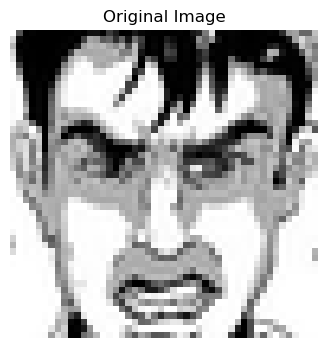

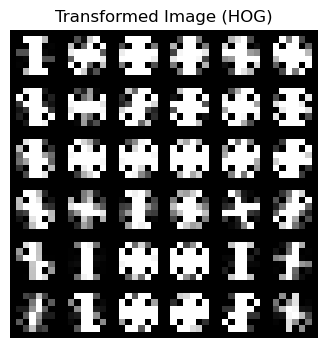

In [6]:
# Visualize an image before and after HOG transformation
index = 22  # Change the index to visualize different images
original_image_pixels = images_train.iloc[index].reshape((48, 48))  # Get the original image pixels

# Compute HOG features for the original image
fd, hog_image = hog(original_image_pixels, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Plot original image
plt.figure(figsize=(4, 4))
plt.imshow(original_image_pixels, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# Plot transformed image after HOG
plt.figure(figsize=(4, 4))
plt.imshow(hog_image_rescaled, cmap='gray')
plt.title('Transformed Image (HOG)')
plt.axis('off')
plt.show()


In [7]:
# Split data into train and test sets after HOG transformation
X = hog_features_train  # Features
y = labels_train  # Labels



# Model 1: Logistic Regression 


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of Logistic Regression on Raw Data: 0.43452380952380953


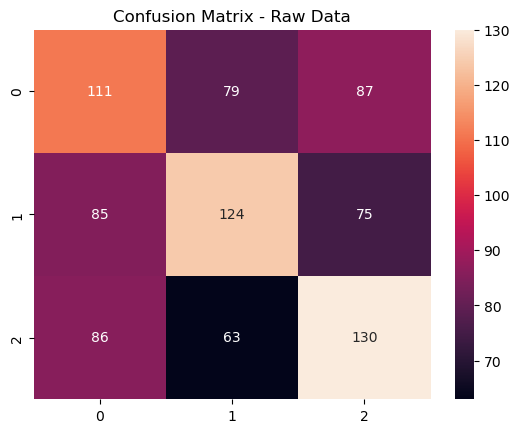

In [8]:
# Model 1: Logistic Regression on Raw Data
log_reg_raw = LogisticRegression(max_iter=5000)  # Initialize Logistic Regression

# Split raw data into train and test sets
X_raw_train, X_raw_test, y_train, y_test = train_test_split(images_train, labels_train, test_size=0.2, random_state=42)

# Flatten the image data
X_raw_train_flat = np.array([x.flatten() for x in X_raw_train])
X_raw_test_flat = np.array([x.flatten() for x in X_raw_test])

# Train the model
log_reg_raw.fit(X_raw_train_flat, y_train)

# Predict on test set
predictions_raw = log_reg_raw.predict(X_raw_test_flat)

# Evaluate accuracy
accuracy_raw = accuracy_score(y_test, predictions_raw)
print("Accuracy of Logistic Regression on Raw Data:", accuracy_raw)

# Confusion Matrix
conf_matrix_raw = confusion_matrix(y_test, predictions_raw)
sns.heatmap(conf_matrix_raw, annot=True, fmt='d')
plt.title("Confusion Matrix - Raw Data")
plt.show()


Accuracy of Logistic Regression on HOG Features: 0.6766666666666666


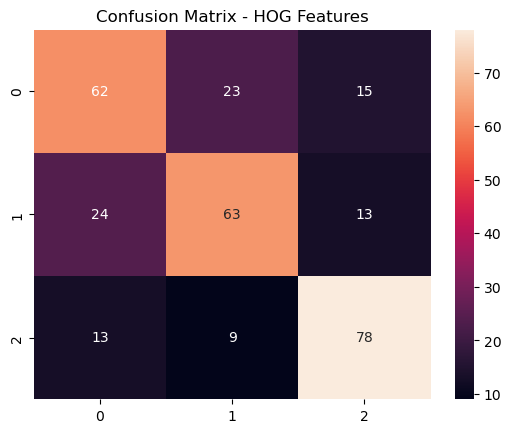

In [9]:
# Model 2: Logistic Regression on HOG Features
log_reg_hog = LogisticRegression(max_iter=5000)  # Initialize Logistic Regression

# Train the model
log_reg_hog.fit(hog_features_train, labels_train)

# Predict on test set (HOG features)
predictions_hog = log_reg_hog.predict(hog_features_test)

# Evaluate accuracy
accuracy_hog = accuracy_score(labels_test, predictions_hog)
print("Accuracy of Logistic Regression on HOG Features:", accuracy_hog)

# Confusion Matrix
conf_matrix_hog = confusion_matrix(labels_test, predictions_hog)
sns.heatmap(conf_matrix_hog, annot=True, fmt='d')
plt.title("Confusion Matrix - HOG Features")
plt.show()


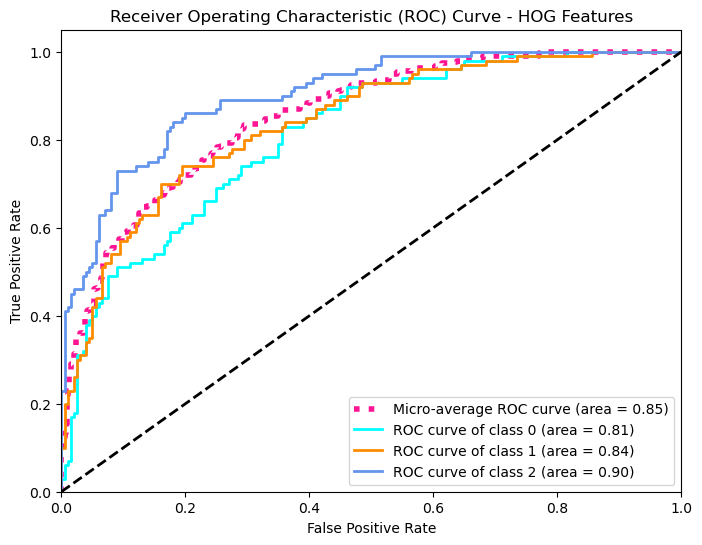

In [10]:
# Get predicted probabilities for each class
probabilities = log_reg_hog.predict_proba(hog_features_test)

# Binarize the labels
binary_labels = label_binarize(labels_test, classes=[0, 2, 3])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len([0, 2, 3])):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(binary_labels.ravel(), probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

# Plot individual class ROC curves
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(len([0, 2, 3])), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - HOG Features')
plt.legend(loc="lower right")
plt.show()


# Model 2: KMEANS


In [11]:
# Apply feature scaling to HOG features
scaler = StandardScaler()
hog_features_train_scaled = scaler.fit_transform(hog_features_train)

# Apply KMeans clustering on scaled HOG features
kmeans = KMeans(n_clusters=len(np.unique(labels_train)), random_state=42)  # Adjust parameters as needed
kmeans.fit(hog_features_train_scaled)

# Predict the cluster labels for the training data
predicted_labels = kmeans.predict(hog_features_train_scaled)

# Evaluate accuracy
accuracy = accuracy_score(labels_train, predicted_labels)
print(f"Accuracy using KMeans as a classifier with feature scaling: {accuracy * 100:.2f}%")


D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy using KMeans as a classifier with feature scaling: 24.95%


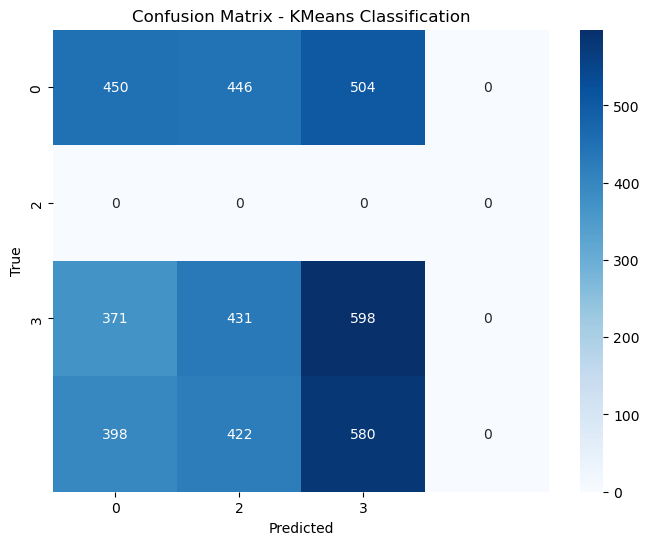

In [12]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(labels_train, predicted_labels)

# Plotting the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(labels_train), yticklabels=np.unique(labels_train))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - KMeans Classification')
plt.show()

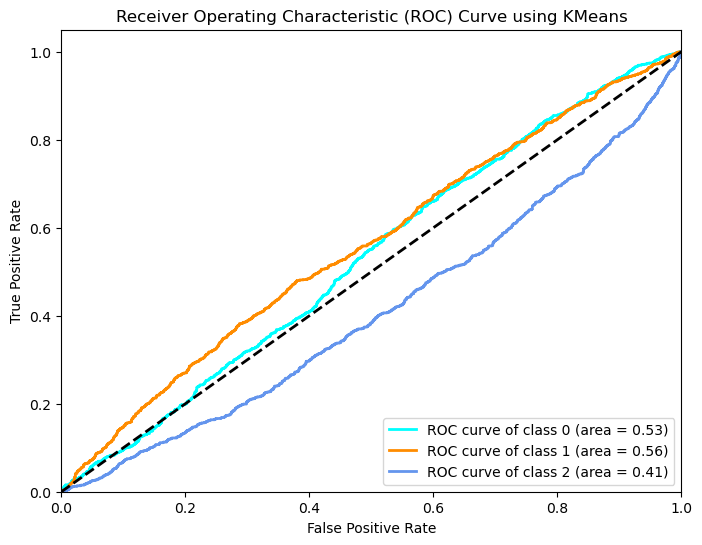

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Calculate distances from each sample to each cluster center
cluster_centers = kmeans.cluster_centers_
distances = np.sqrt(((hog_features_train_scaled - cluster_centers[:, np.newaxis])**2).sum(axis=2))

# Use minimum distance as a surrogate score for each sample
surrogate_scores = np.min(distances, axis=0)

# Binarize the labels for multi-class classification
binary_labels = label_binarize(labels_train, classes=np.unique(labels_train))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(binary_labels.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], surrogate_scores)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['aqua', 'darkorange', 'cornflowerblue']  # Define colors for classes
for i, color in zip(range(binary_labels.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve using KMeans')
plt.legend(loc="lower right")
plt.show()